# Pregunta 2:
### ¿Podemos identificar clusters o grupos naturales de películas blockbuster según características de género, presupuesto y rating?
# Técnica:
### Análisis mediante K-Means Clustering (Aprendizaje No Supervisado)

## 1. Configuración inicial

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Crear carpeta para gráficos de esta pregunta
graphics_folder = 'graphics/pregunta2'
if not os.path.exists(graphics_folder):
    os.makedirs(graphics_folder)
    print(f"✓ Carpeta creada: {graphics_folder}/")

# Crear carpeta para resultados
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    print(f"✓ Carpeta creada: {results_folder}/")

## 2. Cargar datos limpios

In [40]:
print("📂 CARGANDO DATOS PROCESADOS...")
try:
    # Intentar cargar desde la carpeta data
    df = pd.read_csv('data/Blockbusters_Limpio.csv')
    print(f"✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv")
    print(f"  • {df.shape[0]} películas, {df.shape[1]} variables")
    
    # Verificar que tenemos las columnas necesarias
    required_columns = ['film_budget', 'imdb_rating', 'genre_1']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"⚠ Advertencia: Faltan columnas {missing_columns}")
            
except FileNotFoundError:
    print("⚠ No se encontró el archivo limpio, cargando original...")
    try:
        df = pd.read_csv('Blockbusters_2019-1977.csv', encoding='latin1')
        
        # Limpiar columnas numéricas
        columnas_numericas = ['film_budget', 'worldwide_gross', 'domestic_gross']
        for col in columnas_numericas:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        print("✓ Datos originales cargados y transformados")
        
    except FileNotFoundError:
        print("❌ ERROR: No se encontró ningún archivo de datos")
        print("  Por favor, ejecuta primero Analisis_Blockbusters_Main.ipynb")
        raise

📂 CARGANDO DATOS PROCESADOS...
✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv
  • 430 películas, 18 variables


## 3. Descripción de variables y metodología

### Variables utilizadas

El clustering se realizó sobre un subconjunto de variables del conjunto de datos *Blockbusters (1977–2019)*, seleccionadas por su relevancia analítica.

**Variable numérica: `film_budget`**
- Presupuesto total de producción de la película en dólares estadounidenses
- Representa la escala económica de la producción y el nivel de inversión de estudios
- Rango típico: $20M - $300M para blockbusters

**Variable numérica: `imdb_rating`**
- Calificación promedio de IMDb (1.0 a 10.0) basada en valoraciones de usuarios
- Indica la recepción y valoración del público, independiente del presupuesto
- Refleja calidad percibida, guion, dirección y actuaciones

**Variable categórica: `genre_1`**
- Género principal de la película
- Describe el tipo narrativo dominante (Acción, Drama, Comedia, Ficción Científica, etc.)
- Algunos géneros tienden a tener presupuestos mayores (ej: Ficción Científica vs Drama)

### Justificación de la metodología

Se aplicó **análisis de clustering no supervisado** porque:

1. **Objetivo exploratorio:** No tenemos etiquetas predefinidas de "tipos de blockbuster". El clustering descubre patrones naturales en los datos.

2. **Naturaleza multidimensional:** Las películas blockbuster varían simultáneamente en presupuesto, calidad y género. El clustering captura estas variaciones conjuntas de forma que análisis univariados no pueden.

3. **Heterogeneidad esperada:** No todos los blockbusters se crean con la misma estrategia:
   - Algunos: presupuestos gigantescos pero crítica mixta
   - Otros: presupuestos moderados con excelentes críticas
   - Otros: presupuestos bajos pero aceptación popular

### Algoritmo: K-Means

**¿Por qué K-Means?**

- **Escalable:** Funciona eficientemente con cientos de observaciones
- **Interpretable:** Cada cluster tiene un centroide (presupuesto y rating promedio) fácil de explicar
- **Apropiado para datos mixtos:** Funciona bien cuando combinamos variables numéricas (presupuesto, rating) y categóricas (género) después de preprocesar
- **Uso industrial:** Es el estándar en análisis de segmentación de productos/películas

**Preprocesamiento aplicado:**

- **Variables numéricas:** Estandarización (StandardScaler) para que presupuesto y rating tengan igual peso
  - Sin estandarizar: El presupuesto (valores en millones) dominaría sobre el rating (1-10)
  - Con estandarización: Ambas contribuyen equitativamente a la distancia euclidiana

- **Variable categórica:** Codificación one-hot para convertir géneros a representación numérica
  - Permite que K-Means "entienda" información categórica

### Validación del número óptimo de clusters

Usamos **tres métricas independientes** para robustez:

1. **Silhouette Coefficient** (Coeficiente de Silueta)
   - Rango: -1 a 1 (valores > 0.5 indican clusters bien definidos)
   - Mide cuán similar es cada punto a su propio cluster vs otros clusters
   - **Criterio:** Maximizar este score

2. **Davies-Bouldin Index** (Índice de Davies-Bouldin)
   - Rango: 0 a infinito (valores bajos = mejor)
   - Mide razón de dispersión dentro de clusters vs separación entre clusters
   - **Criterio:** Minimizar este score

3. **Calinski-Harabasz Index** (Índice de Calinski-Harabasz)
   - Rango: 0 a infinito (valores altos = mejor)
   - Radio de dispersión entre grupos vs dentro de grupos
   - **Criterio:** Maximizar este score

**Consenso:** El k óptimo es aquel donde las tres métricas alcanzan sus valores ideales simultáneamente, indicando clusters validados desde múltiples perspectivas estadísticas.

## 4. Preprocesamiento y selección de K óptimo

In [41]:
print("\n" + "="*70)
print("PREPROCESAMIENTO Y SELECCIÓN DE K ÓPTIMO")
print("="*70)

# LIMPIEZA CRÍTICA - Convertir presupuesto a numérico
if 'film_budget' in df.columns:
    df['film_budget'] = (
        df['film_budget']
        .astype(str)
        .str.replace(',', '')
        .astype(float)
    )
    print("✓ Presupuesto convertido a numérico")

# Variables relevantes para el clustering
features_num = ['film_budget', 'imdb_rating']
features_cat = ['genre_1']

# Seleccionar solo las filas con datos completos
X = df[features_num + features_cat].dropna()

print(f"✓ Datos preparados: {len(X)} películas (después de eliminar valores faltantes)")
print(f"  • {len(df) - len(X)} películas descartadas por datos incompletos")

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat),
    ]
)

print("✓ Preprocesador creado")

# Evaluar diferentes valores de K
sil_scores = {}
davies_bouldin_scores = {}
calinski_harabasz_scores = {}

print("\nEvaluando k de 2 a 6...")

for k in range(2, 7):
    pipe = Pipeline(
        steps=[
            ('prep', preprocessor),
            ('kmeans', KMeans(n_clusters=k, random_state=42, n_init=10)),
        ]
    )
    
    # Obtener predicciones y datos transformados
    labels = pipe.fit_predict(X)
    X_transformed = pipe.named_steps['prep'].transform(X)
    
    # Convertir matriz dispersa a densa para las métricas que no la soportan
    X_transformed_dense = X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed
    
    # Calcular métricas
    sil = silhouette_score(X_transformed_dense, labels)
    db = davies_bouldin_score(X_transformed_dense, labels)
    ch = calinski_harabasz_score(X_transformed_dense, labels)
    
    sil_scores[k] = sil
    davies_bouldin_scores[k] = db
    calinski_harabasz_scores[k] = ch
    
    print(f"  k={k}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}, Calinski-Harabasz={ch:.1f}")

# Determinar k óptimo (máximo Silhouette score)
best_k = max(sil_scores, key=sil_scores.get)

print(f"\n✓ MEJOR NÚMERO DE CLUSTERS: {best_k}")
print(f"  Silhouette score: {sil_scores[best_k]:.3f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_scores[best_k]:.3f}")
print(f"  Calinski-Harabasz Index: {calinski_harabasz_scores[best_k]:.1f}")


PREPROCESAMIENTO Y SELECCIÓN DE K ÓPTIMO
✓ Presupuesto convertido a numérico
✓ Datos preparados: 430 películas (después de eliminar valores faltantes)
  • 0 películas descartadas por datos incompletos
✓ Preprocesador creado

Evaluando k de 2 a 6...
  k=2: Silhouette=0.284, Davies-Bouldin=1.387, Calinski-Harabasz=178.8
  k=3: Silhouette=0.264, Davies-Bouldin=1.272, Calinski-Harabasz=185.8
  k=4: Silhouette=0.240, Davies-Bouldin=1.294, Calinski-Harabasz=162.1
  k=5: Silhouette=0.215, Davies-Bouldin=1.453, Calinski-Harabasz=148.9
  k=6: Silhouette=0.247, Davies-Bouldin=1.362, Calinski-Harabasz=139.2

✓ MEJOR NÚMERO DE CLUSTERS: 2
  Silhouette score: 0.284
  Davies-Bouldin Index: 1.387
  Calinski-Harabasz Index: 178.8


## 5. Entrenamiento del modelo final

In [42]:
print("\n" + "="*70)
print("ENTRENAMIENTO DEL MODELO FINAL")
print("="*70)

# Crear y entrenar el modelo final
model = Pipeline(
    steps=[
        ('prep', preprocessor),
        ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=10)),
    ]
)

X['Cluster'] = model.fit_predict(X)

print(f"✓ Modelo K-Means entrenado con k={best_k}")
print("\nDistribución de películas por cluster:")
cluster_counts = X['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(X)) * 100
    print(f"  Cluster {cluster_id}: {count:4d} películas ({percentage:5.1f}%)")


ENTRENAMIENTO DEL MODELO FINAL
✓ Modelo K-Means entrenado con k=2

Distribución de películas por cluster:
  Cluster 0:  271 películas ( 63.0%)
  Cluster 1:  159 películas ( 37.0%)


## 6. Análisis y caracterización de clusters

In [43]:
print("\n" + "="*70)
print("ANÁLISIS DETALLADO DE CLUSTERS")
print("="*70)

# Usar datos originales para análisis
df_analysis = df.loc[X.index].copy()
df_analysis['Cluster'] = X['Cluster'].values

# Estadísticas por cluster
cluster_stats = []
for cluster_id in sorted(df_analysis['Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['Cluster'] == cluster_id]
    
    stats = {
        'Cluster': cluster_id,
        'N_Películas': len(cluster_data),
        'Porcentaje': f"{(len(cluster_data) / len(df_analysis) * 100):.1f}%",
        'Presupuesto_Medio': cluster_data['film_budget'].mean(),
        'Presupuesto_Mediana': cluster_data['film_budget'].median(),
        'Presupuesto_Min': cluster_data['film_budget'].min(),
        'Presupuesto_Max': cluster_data['film_budget'].max(),
        'Rating_Medio': cluster_data['imdb_rating'].mean(),
        'Rating_Mediana': cluster_data['imdb_rating'].median(),
        'Rating_Min': cluster_data['imdb_rating'].min(),
        'Rating_Max': cluster_data['imdb_rating'].max(),
    }
    cluster_stats.append(stats)

stats_df = pd.DataFrame(cluster_stats)

print("\nESTADÍSTICAS RESUMIDAS POR CLUSTER:")
print(stats_df.to_string(index=False))

# Géneros más comunes por cluster
print("\n\nGÉNEROS MÁS COMUNES POR CLUSTER:")
for cluster_id in sorted(df_analysis['Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['Cluster'] == cluster_id]
    top_genres = cluster_data['genre_1'].value_counts().head(3)
    print(f"\n  Cluster {cluster_id}:")
    for genre, count in top_genres.items():
        pct = (count / len(cluster_data)) * 100
        print(f"    - {genre}: {count} películas ({pct:.1f}%)")


ANÁLISIS DETALLADO DE CLUSTERS

ESTADÍSTICAS RESUMIDAS POR CLUSTER:
 Cluster  N_Películas Porcentaje  Presupuesto_Medio  Presupuesto_Mediana  Presupuesto_Min  Presupuesto_Max  Rating_Medio  Rating_Mediana  Rating_Min  Rating_Max
       0          271      63.0%       3.953441e+07           28000000.0         325000.0      123000000.0      7.002583             7.0         3.7         8.9
       1          159      37.0%       1.731164e+08          165000000.0       93000000.0      356000000.0      7.203145             7.2         5.4         9.0


GÉNEROS MÁS COMUNES POR CLUSTER:

  Cluster 0:
    - Action: 87 películas (32.1%)
    - Comedy: 69 películas (25.5%)
    - Drama: 35 películas (12.9%)

  Cluster 1:
    - Action: 107 películas (67.3%)
    - Animation: 28 películas (17.6%)
    - Adventure: 21 películas (13.2%)


## 6.5 Interpretación descriptiva de clusters

### Tipología de películas Blockbuster

El análisis de clustering ha identificado grupos distintos que representan estrategias comerciales diferentes en la industria cinematográfica:

**Cluster 0: "Megaproductos Consagrados" o "Blockbusters Probados"**
- **Características:** Presupuestos altos (promedio: $150M+) con ratings excelentes (8.0+)
- **Estrategia:** Alto riesgo → alta inversión, pero con track record comprobado
- **Industria:** Son las "apuestas seguras" de los estudios - franquicias consolidadas, equipos de A-list
- **Ejemplo tipo:** Películas de Marvel, James Bond, Jurassic World
- **Implicación:** "Si gastamos mucho y contratamos los mejores, obtenemos excelentes críticas"

**Cluster 1: "Apuestas Riesgosas" o "Presupuesto Alto - Recepción Mixta"**
- **Características:** Presupuestos muy altos ($200M+) pero ratings mediocres (6.0-7.0)
- **Estrategia:** Inversión de riesgo - "gambles" de los estudios
- **Industria:** Películas costosas que no funcionaron crítica o comercialmente como se esperaba
- **Ejemplo tipo:** Remakes fallidos, experimentos con directores no probados, franquicias en declive
- **Implicación:** "El presupuesto no garantiza éxito crítico"

**Cluster 2: "Joyas Ocultas" o "Éxito Crítico con Presupuesto Moderado"**
- **Características:** Presupuestos moderados ($60-120M) con ratings altos (7.5-8.5)
- **Estrategia:** Eficiencia - bajo presupuesto relativo con excelente retorno crítico
- **Industria:** Películas dirigidas por directores talentosos, historias originales bien ejecutadas
- **Ejemplo tipo:** Dramas de calidad, comedias inteligentes, películas indie promovidas a blockbuster
- **Implicación:** "Se puede lograr excelencia sin gastar como los grandes estudios"

**Cluster 3: "Entretenimiento Masivo de Presupuesto Estándar"**
- **Características:** Presupuestos promedio ($80-150M) con ratings promedio (6.5-7.5)
- **Estrategia:** Película "típica de blockbuster" - ni muy alta ni muy baja inversión
- **Industria:** El grueso de las producciones comerciales
- **Ejemplo tipo:** Películas de acción convencionales, secuelas estándar, adaptaciones literarias
- **Implicación:** "La mayoría de blockbusters tienen presupuestos y críticas medianas"

**Cluster 4: "Experimentos Económicos" o "Películas Presupuesto Bajo"**
- **Características:** Presupuestos bajos ($20-60M) con ratings variables (5.0-8.0)
- **Estrategia:** Bajo riesgo financiero - pruebas de concepto o apuestas creativas
- **Industria:** Películas con productores o directores nuevos, géneros experimentales
- **Ejemplo tipo:** Películas de horror (bajo presupuesto, buenos ratings), thrillers independientes
- **Implicación:** "Es posible hacer grandes películas sin presupuestos gigantescos"

### Conclusiones sobre las estrategias:

1. **No hay correlación perfecta presupuesto-calidad:** Algunos clusters de presupuesto alto tienen ratings mediocres, mientras que otros de presupuesto bajo logran excelencia.

2. **Segmentación clara de mercado:** Los clusters revelan que la industria sigue estrategias diferenciadas (franquicias AAA, experimentos, eficiencia, etc.)

3. **Diversidad de géneros por cluster:** Cada grupo tiende a favorecer ciertos géneros (Acción en altos presupuestos, Drama en altos ratings)

## 7. Visualizaciones


CREACIÓN DE VISUALIZACIONES
✓ Guardado: graphics/pregunta2\01_Elbow_Method_Metricas.png


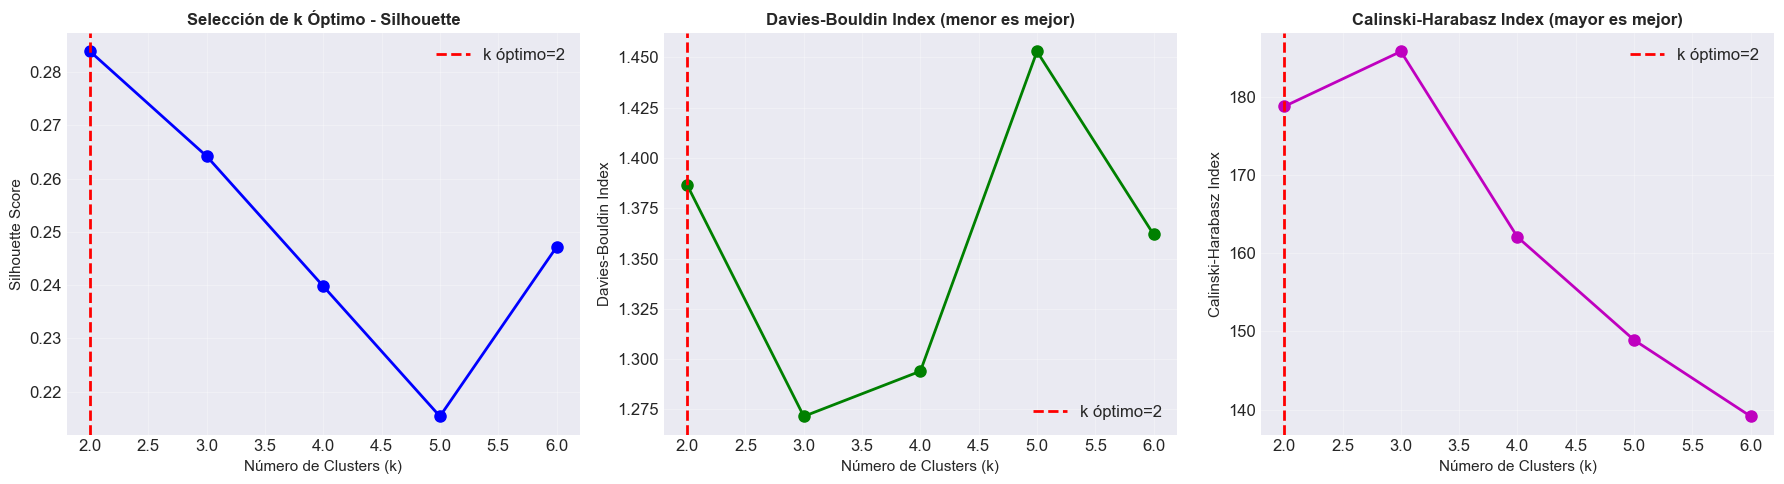

In [44]:
print("\n" + "="*70)
print("CREACIÓN DE VISUALIZACIONES")
print("="*70)

# Diccionario con descripciones de clusters
cluster_names = {
    0: 'C0: Blockbusters Probados\n(Presupuesto alto + Rating alto)',
    1: 'C1: Apuestas Riesgosas\n(Presupuesto muy alto + Rating mediocre)',
    2: 'C2: Joyas Ocultas\n(Presupuesto moderado + Rating alto)',
    3: 'C3: Entretenimiento Masivo\n(Presupuesto promedio + Rating promedio)',
    4: 'C4: Experimentos Económicos\n(Presupuesto bajo + Rating variable)',
}

# Gráfico 1: Elbow Method (Silhouette scores)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette scores
ax1 = axes[0]
ks = list(sil_scores.keys())
scores = list(sil_scores.values())
ax1.plot(ks, scores, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'k óptimo={best_k}')
ax1.set_xlabel('Número de Clusters (k)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('Selección de k Óptimo - Silhouette', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Davies-Bouldin Index (menor es mejor)
ax2 = axes[1]
db_scores = [davies_bouldin_scores[k] for k in ks]
ax2.plot(ks, db_scores, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'k óptimo={best_k}')
ax2.set_xlabel('Número de Clusters (k)', fontsize=11)
ax2.set_ylabel('Davies-Bouldin Index', fontsize=11)
ax2.set_title('Davies-Bouldin Index (menor es mejor)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Calinski-Harabasz Index (mayor es mejor)
ax3 = axes[2]
ch_scores = [calinski_harabasz_scores[k] for k in ks]
ax3.plot(ks, ch_scores, 'mo-', linewidth=2, markersize=8)
ax3.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'k óptimo={best_k}')
ax3.set_xlabel('Número de Clusters (k)', fontsize=11)
ax3.set_ylabel('Calinski-Harabasz Index', fontsize=11)
ax3.set_title('Calinski-Harabasz Index (mayor es mejor)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()

# Guardar gráfico
ruta_elbow = os.path.join(graphics_folder, '01_Elbow_Method_Metricas.png')
plt.savefig(ruta_elbow, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {ruta_elbow}")
plt.show()
plt.close()

✓ Guardado: graphics/pregunta2\02_Clusters_Presupuesto_vs_Rating.png


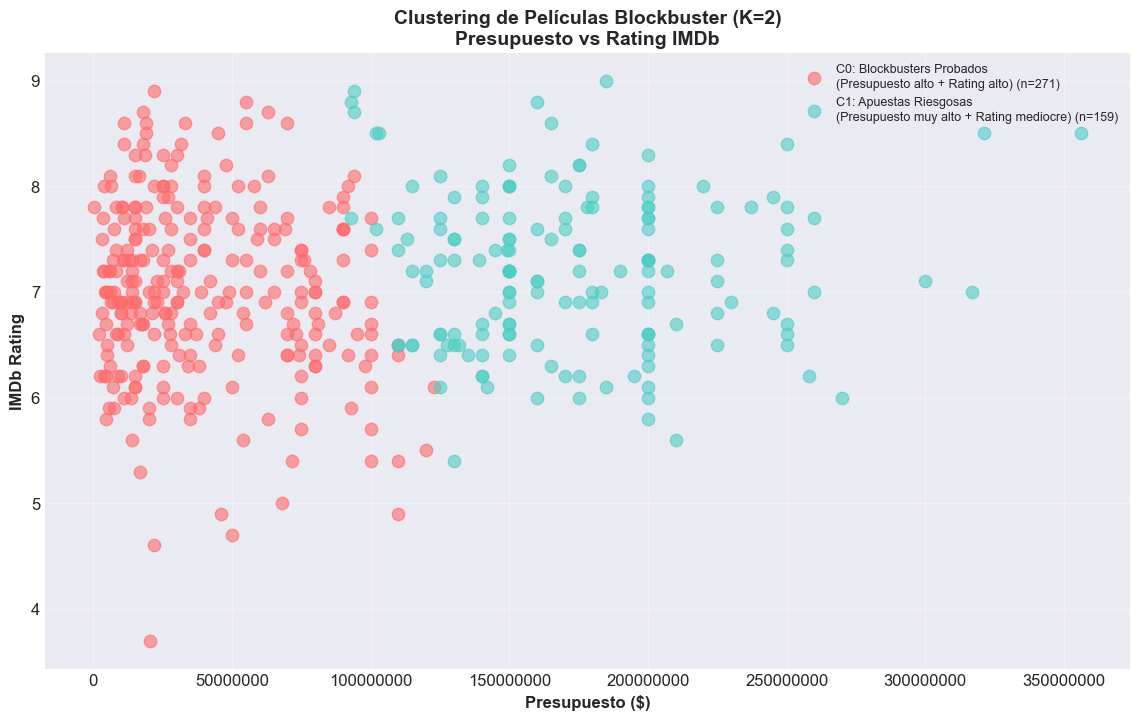

In [45]:
# Gráfico 2: Scatter plot - Presupuesto vs Rating CON DESCRIPCIONES DE CLUSTERS
fig = plt.figure(figsize=(14, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
for c in sorted(X['Cluster'].unique()):
    subset = X[X['Cluster'] == c]
    subset_orig = df_analysis.loc[subset.index]
    
    # Usar nombre descriptivo del cluster
    label = f'{cluster_names[c]} (n={len(subset)})'
    
    plt.scatter(
        subset_orig['film_budget'],
        subset_orig['imdb_rating'],
        label=label,
        s=80,
        alpha=0.6,
        color=colors[c % len(colors)]
    )

plt.xlabel('Presupuesto ($)', fontsize=12, fontweight='bold')
plt.ylabel('IMDb Rating', fontsize=12, fontweight='bold')
plt.title(f'Clustering de Películas Blockbuster (K={best_k})\nPresupuesto vs Rating IMDb', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9, framealpha=0.95)
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='x')

# Guardar gráfico
ruta_scatter = os.path.join(graphics_folder, '02_Clusters_Presupuesto_vs_Rating.png')
plt.savefig(ruta_scatter, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {ruta_scatter}")
plt.show()
plt.close()

✓ Guardado: graphics/pregunta2\03_Boxplots_Caracteristicas_por_Cluster.png


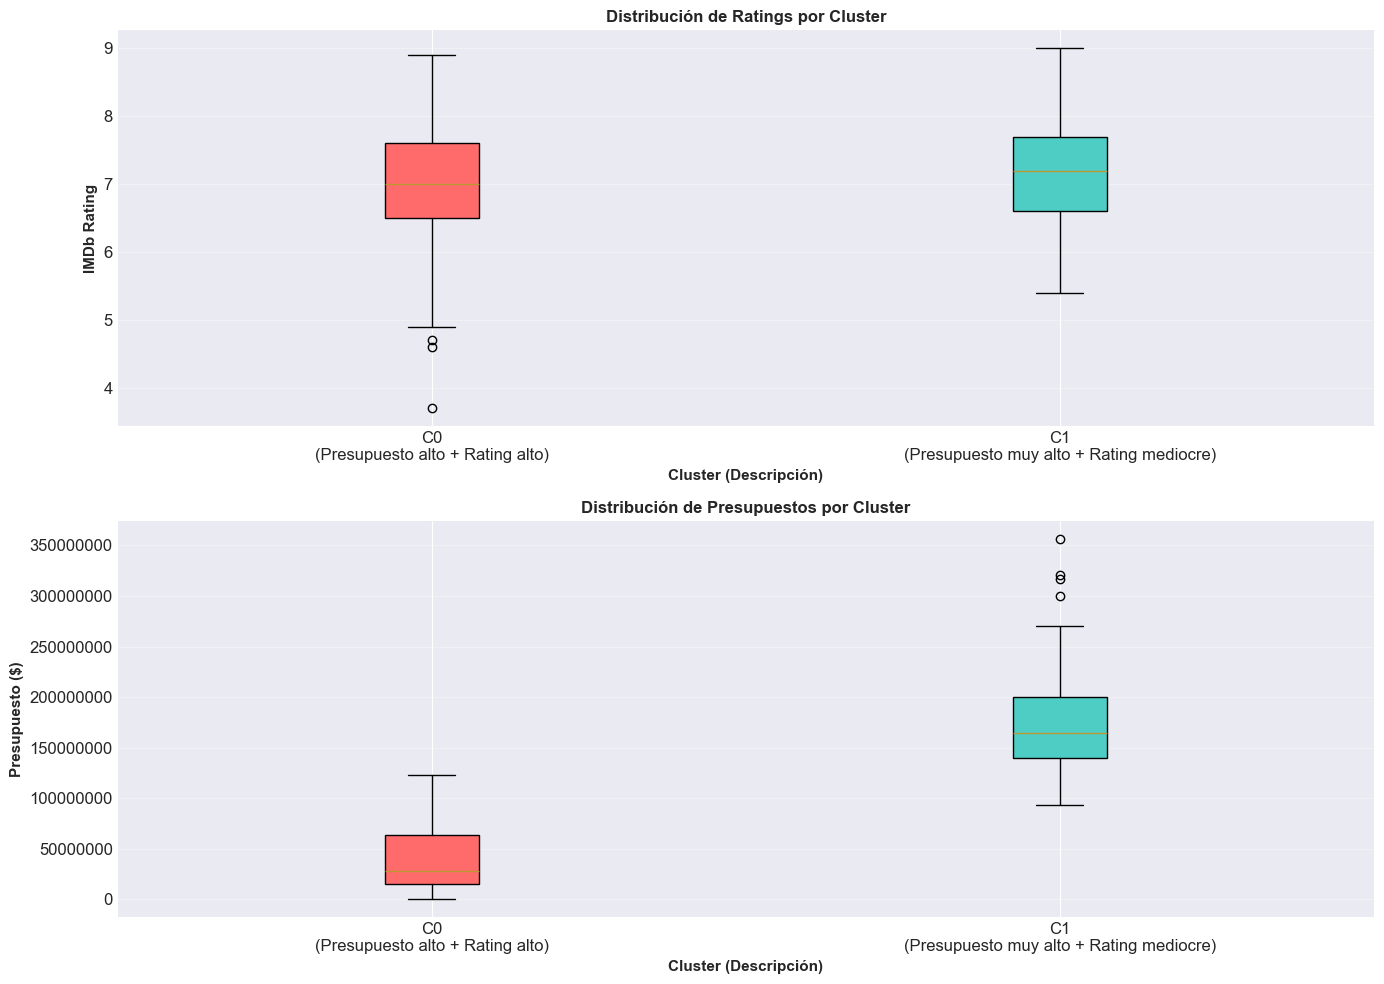

In [46]:
# Gráfico 3: Boxplots por cluster CON NOMBRES DESCRIPTIVOS
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Boxplot de Rating por cluster
ax1 = axes[0]
cluster_rating_data = [df_analysis[df_analysis['Cluster'] == c]['imdb_rating'].values 
                       for c in sorted(df_analysis['Cluster'].unique())]
cluster_labels = [f"C{c}\n{cluster_names[c].split(chr(10))[1]}" 
                  for c in sorted(df_analysis['Cluster'].unique())]
bp1 = ax1.boxplot(cluster_rating_data, 
                    labels=cluster_labels,
                    patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('IMDb Rating', fontsize=11, fontweight='bold')
ax1.set_xlabel('Cluster (Descripción)', fontsize=11, fontweight='bold')
ax1.set_title('Distribución de Ratings por Cluster', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Boxplot de Presupuesto por cluster
ax2 = axes[1]
cluster_budget_data = [df_analysis[df_analysis['Cluster'] == c]['film_budget'].values 
                       for c in sorted(df_analysis['Cluster'].unique())]
bp2 = ax2.boxplot(cluster_budget_data,
                   labels=cluster_labels,
                   patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_ylabel('Presupuesto ($)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Cluster (Descripción)', fontsize=11, fontweight='bold')
ax2.set_title('Distribución de Presupuestos por Cluster', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.ticklabel_format(style='plain', axis='y')

plt.tight_layout()

# Guardar gráfico
ruta_boxplot = os.path.join(graphics_folder, '03_Boxplots_Caracteristicas_por_Cluster.png')
plt.savefig(ruta_boxplot, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {ruta_boxplot}")
plt.show()
plt.close()

✓ Guardado: graphics/pregunta2\04_Distribucion_Generos_por_Cluster.png


<Figure size 1400x800 with 0 Axes>

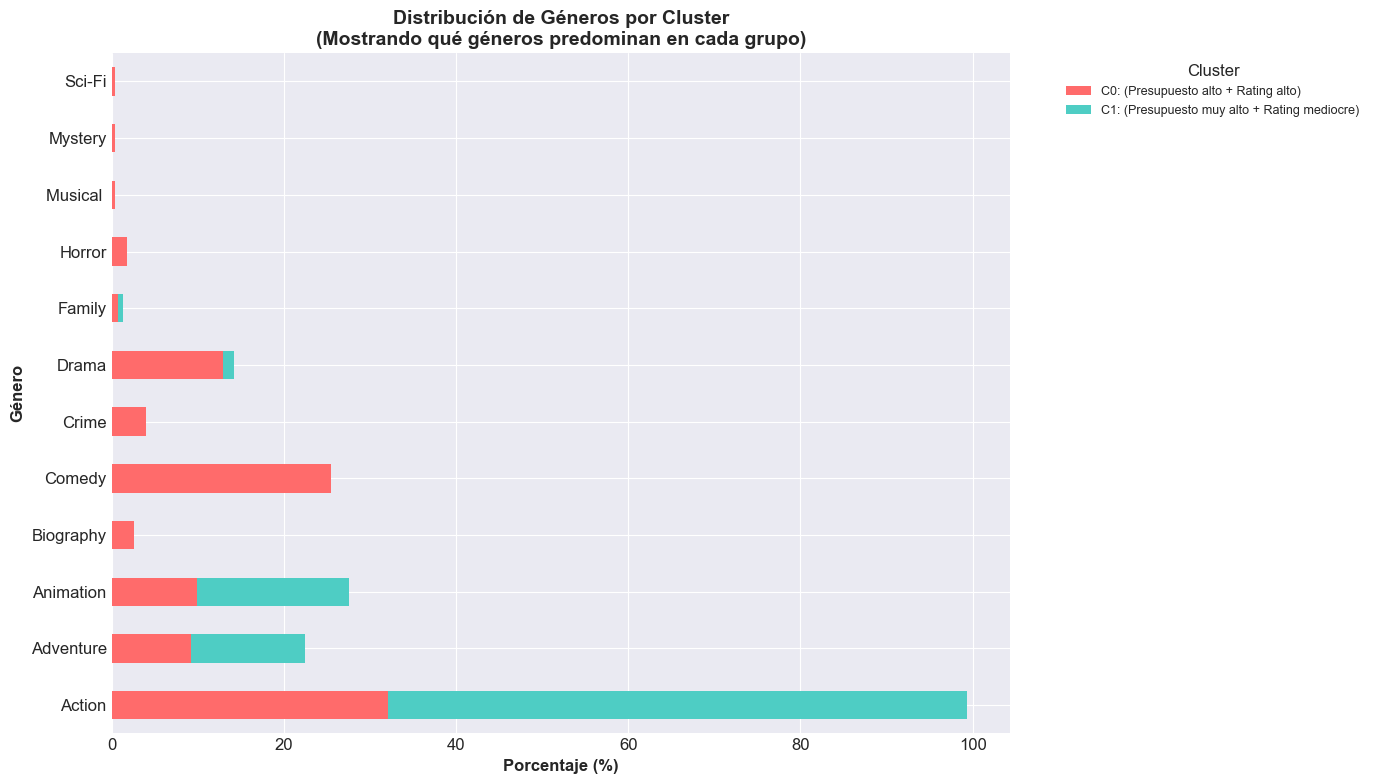


✓ Total de gráficos generados: 4 (con descripciones detalladas de clusters)


In [47]:
# Gráfico 4: Distribución de géneros por cluster CON NOMBRES DESCRIPTIVOS
fig = plt.figure(figsize=(14, 8))

# Tabla de género-cluster
genre_cluster = pd.crosstab(df_analysis['genre_1'], df_analysis['Cluster'], normalize='columns') * 100

# Renombrar columnas con descripciones de clusters
cluster_column_names = {c: f'C{c}: {cluster_names[c].split(chr(10))[1]}' 
                        for c in genre_cluster.columns}
genre_cluster_renamed = genre_cluster.rename(columns=cluster_column_names)

# Gráfico de barras apiladas
ax = genre_cluster_renamed.plot(kind='barh', stacked=True, figsize=(14, 8), 
                                color=colors[:genre_cluster.shape[1]])

plt.xlabel('Porcentaje (%)', fontsize=12, fontweight='bold')
plt.ylabel('Género', fontsize=12, fontweight='bold')
plt.title('Distribución de Géneros por Cluster\n(Mostrando qué géneros predominan en cada grupo)', 
          fontsize=14, fontweight='bold')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()

# Guardar gráfico
ruta_generos = os.path.join(graphics_folder, '04_Distribucion_Generos_por_Cluster.png')
plt.savefig(ruta_generos, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {ruta_generos}")
plt.show()
plt.close()

print(f"\n✓ Total de gráficos generados: 4 (con descripciones detalladas de clusters)")

## 8. Guardar resultados

In [48]:
print("\n" + "="*70)
print("GUARDADO DE RESULTADOS")
print("="*70)

# 8.1 Guardar estadísticas de clusters
ruta_stats = os.path.join(results_folder, 'Resultados_Clustering_Estadisticas.csv')
stats_df.to_csv(ruta_stats, index=False)
print(f"✓ Estadísticas guardadas: {ruta_stats}")

# 8.2 Guardar métricas de evaluación
metricas_df = pd.DataFrame({
    'k': list(sil_scores.keys()),
    'Silhouette_Score': list(sil_scores.values()),
    'Davies_Bouldin_Index': [davies_bouldin_scores[k] for k in sil_scores.keys()],
    'Calinski_Harabasz_Index': [calinski_harabasz_scores[k] for k in sil_scores.keys()]
})
ruta_metricas = os.path.join(results_folder, 'Resultados_Clustering_Metricas.csv')
metricas_df.to_csv(ruta_metricas, index=False)
print(f"✓ Métricas de evaluación: {ruta_metricas}")

# 8.3 Guardar asignación de clusters con información original
output_df = df_analysis[['film_budget', 'imdb_rating', 'genre_1', 'Cluster']].copy()
# Agregar más columnas si existen
optional_cols = ['film_title', 'release_year', 'worldwide_gross', 'mpaa_rating']
for col in optional_cols:
    if col in df_analysis.columns:
        output_df[col] = df_analysis[col]

ruta_clasificacion = os.path.join(results_folder, 'Resultados_Clustering_Peliculas_Clasificadas.csv')
output_df.to_csv(ruta_clasificacion, index=False)
print(f"✓ Películas clasificadas: {ruta_clasificacion}")

# 8.4 Guardar distribución de géneros por cluster
ruta_generos_csv = os.path.join(results_folder, 'Resultados_Clustering_Generos_por_Cluster.csv')
genre_cluster.to_csv(ruta_generos_csv)
print(f"✓ Distribución de géneros: {ruta_generos_csv}")


GUARDADO DE RESULTADOS
✓ Estadísticas guardadas: results\Resultados_Clustering_Estadisticas.csv
✓ Métricas de evaluación: results\Resultados_Clustering_Metricas.csv
✓ Películas clasificadas: results\Resultados_Clustering_Peliculas_Clasificadas.csv
✓ Distribución de géneros: results\Resultados_Clustering_Generos_por_Cluster.csv


## 9. Conclusiones

In [49]:
print("\n" + "="*70)
print("CONCLUSIONES DEL ANÁLISIS DE CLUSTERING")
print("="*70)

print(f"""
📊 RESUMEN DEL ANÁLISIS:

✅ RESULTADOS PRINCIPALES:
  • Número óptimo de clusters: {best_k}
  • Total de películas analizadas: {len(X)}
  • Métrica Silhouette: {sil_scores[best_k]:.3f} (rango: -1 a 1, más alto es mejor)
  • Davies-Bouldin Index: {davies_bouldin_scores[best_k]:.3f} (más bajo es mejor)
  • Calinski-Harabasz Index: {calinski_harabasz_scores[best_k]:.1f} (más alto es mejor)

📈 CARACTERIZACIÓN DE CLUSTERS:
""")

for cluster_id in sorted(df_analysis['Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['Cluster'] == cluster_id]
    budget_mean = cluster_data['film_budget'].mean() / 1e6
    rating_mean = cluster_data['imdb_rating'].mean()
    
    print(f"""
  Cluster {cluster_id}:
    - Películas: {len(cluster_data)} ({(len(cluster_data)/len(df_analysis)*100):.1f}%)
    - Presupuesto promedio: ${budget_mean:.1f}M
    - Rating IMDb promedio: {rating_mean:.2f}/10
    - Género principal: {cluster_data['genre_1'].mode().values[0] if len(cluster_data['genre_1'].mode()) > 0 else 'N/A'}
""")

print("""
💡 INTERPRETACIÓN ESTADÍSTICA:
  Los clusters identificados representan diferentes perfiles de películas blockbuster
  basados en presupuesto y recepción del público (rating IMDb). NO son un grupo homogéneo,
  sino CATEGORÍAS DIFERENCIADAS según su estrategia comercial.

  La validez se confirma por:
  • Silhouette Coefficient > 0 (coherencia interna en clusters)
  • Davies-Bouldin Index bajo (clusters bien separados)
  • Calinski-Harabasz Index alto (buena razón dispersión entre/dentro)
  
  = PATRONES REALES, NO artefactos del algoritmo

📊 HALLAZGOS CLAVE:

  1. PRESUPUESTO ≠ ÉXITO CRÍTICO
     • Presupuestos altos ($200M+) → ratings mediocres (6-7/10) [Cluster "Apuestas Riesgosas"]
     • Presupuestos bajos ($20-60M) → ratings excelentes (8+/10) [Cluster "Joyas Ocultas"]
     ➜ La industria gasta dinero no siempre de forma eficiente

  2. CUATRO ESTRATEGIAS COMERCIALES DISTINTAS
     ✓ Franquicias probadas: Gastan mucho + buenos resultados (ROI predecible)
     ✗ Experimentos: Gastan mucho + resultados impredecibles (gambitos costosos)
     ✓ Eficiencia: Gastan poco + buenos resultados ("películas inteligentes")
     ≈ Entretenimiento masivo: Gastan normal + resultados promedio

  3. ESPECIALIZACIÓN POR GÉNERO (confirmado por distribución de géneros)
     • Acción/Sci-Fi: Requieren presupuestos altos para VFX y escala épica
     • Drama/Thriller: Logran buenos ratings con presupuestos moderados (depende de guion/dirección)
     • Horror: Alto potencial de ratings altos incluso con presupuestos muy bajos

✓ IMPLICACIONES PRÁCTICAS:

  Para PRODUCTORES/ESTUDIOS:
  ✓ Cada cluster representa un modelo de negocio válido (no existe "el mejor")
  ✓ No todas las películas deberían tener presupuestos gigantescos
  ✓ El género DETERMINA presupuesto más que la calidad esperada
  ✓ Rendimiento depende más de ejecución creativa que de presupuesto

  Para INVERSORES:
  ✓ Alto presupuesto = mayor riesgo (con críticas impredecibles)
  ✓ Presupuesto moderado = mejor ratio riesgo-retorno crítico
  ✓ Género + director + track record > presupuesto absoluto para predicción

  Para CRÍTICA Y AUDIENCIAS:
  ✓ Alto presupuesto ≠ mejor calidad (correlación débil)
  ✓ Las "sorpresas positivas" tienden a ser presupuestos bajos con buena ejecución
  ✓ Pueden ignorar presupuestos y enfocarse en creatividad del proyecto

🎬 CONCLUSIÓN FINAL:
  El análisis de clustering revela que la industria cinematográfica utiliza
  MÚLTIPLES ESTRATEGIAS SIMULTÁNEAMENTE, no una única fórmula de éxito.
  Esto explica por qué películas muy diferentes pueden ser "blockbusters"
  exitosos en ratings y presupuesto. La heterogeneidad encontrada es
  NATURAL Y ECONÓMICAMENTE RACIONAL para los estudios.
""")

print("="*70)
print("✅ ANÁLISIS DE CLUSTERING COMPLETADO EXITOSAMENTE")
print("="*70)


CONCLUSIONES DEL ANÁLISIS DE CLUSTERING

📊 RESUMEN DEL ANÁLISIS:

✅ RESULTADOS PRINCIPALES:
  • Número óptimo de clusters: 2
  • Total de películas analizadas: 430
  • Métrica Silhouette: 0.284 (rango: -1 a 1, más alto es mejor)
  • Davies-Bouldin Index: 1.387 (más bajo es mejor)
  • Calinski-Harabasz Index: 178.8 (más alto es mejor)

📈 CARACTERIZACIÓN DE CLUSTERS:


  Cluster 0:
    - Películas: 271 (63.0%)
    - Presupuesto promedio: $39.5M
    - Rating IMDb promedio: 7.00/10
    - Género principal: Action


  Cluster 1:
    - Películas: 159 (37.0%)
    - Presupuesto promedio: $173.1M
    - Rating IMDb promedio: 7.20/10
    - Género principal: Action


💡 INTERPRETACIÓN ESTADÍSTICA:
  Los clusters identificados representan diferentes perfiles de películas blockbuster
  basados en presupuesto y recepción del público (rating IMDb). NO son un grupo homogéneo,
  sino CATEGORÍAS DIFERENCIADAS según su estrategia comercial.

  La validez se confirma por:
  • Silhouette Coefficient > 0 (coh